The purpose of this notebook is to demonstrate how to obtain Ortho, DSM and DTM tiles from the API in cases where the ExtractOrthoImages tile isn't appropriate e.g if more than 135 tiles will be required. The notebook does the following:
- Takes a polygon for an AOI geometry
- Determines the tile coordinates for covering that polygon
- Downloads each of the tiles for those coordinates
- Georeferences each PNG tile into a TIF
- Creates a mosaic from the set of tiles

## Step 0: set up

In [1]:
import requests
import os

In [2]:
from vdp_python_tools.get_images import tiles_in_polygon, georeference_raster_tile
from vdp_python_tools.authentication import login
from vdp_python_tools.coverage_api_utilities import create_coverage_dataframe


token = login()

## Step 1: 

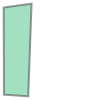

In [4]:
import geopandas as gpd

gdf_aoi = gpd.read_file("../data/sample/example_boundary.shp")
aoi_geometry = gdf_aoi.iloc[0].geometry
aoi_geometry

It's always a good idea to check the coverage before downloading, so do that next.

In [5]:
gdf_coverage = create_coverage_dataframe(wkt=aoi_geometry.wkt)
gdf_coverage.head()

,geometry,Name,Coverage Type,Min GSD,Max GSD,Min Date,Max Date,Max Zoom,Z Index,Camera Technology,layer
0,"MULTIPOLYGON (((8.89120 48.68340, 8.89150 48.6...",de-bw-stuttgart-2020,dxm-ortho,0.061599,0.078231,2020-07-12 06:58:57,2020-07-31 07:12:55,21,50,,bluesky-ultra-europe
1,"MULTIPOLYGON (((8.52670 47.97950, 8.31230 47.9...",n48e9-de-bw-gaggenau-2020,final-ortho,0.151560,0.196013,2020-04-15 07:49:18,2020-04-15 02:37:13,20,0,None,bluesky-high-europe


The function below does the following:
    - creates a bounding box around the `aoi_geometry`
    - calculates the tiles within that bounding box
    - creates a geometry for each tile
    - adds that tile to a list if that tile intersects the `aoi_geometry`
    - returns the list
    
If you set `output_format` to "GeoDaa

In [6]:
tile_coords = tiles_in_polygon(aoi_geometry, 17)
tile_coords

[(68772, 45171, 17),
 (68772, 45172, 17),
 (68772, 45173, 17),
 (68772, 45174, 17),
 (68772, 45175, 17),
 (68772, 45176, 17),
 (68772, 45177, 17),
 (68772, 45178, 17),
 (68772, 45179, 17),
 (68772, 45180, 17),
 (68773, 45171, 17),
 (68773, 45172, 17),
 (68773, 45173, 17),
 (68773, 45174, 17),
 (68773, 45175, 17),
 (68773, 45176, 17),
 (68773, 45177, 17),
 (68773, 45178, 17),
 (68773, 45179, 17),
 (68773, 45180, 17)]

In [7]:
import shutil 

format_type = "png"
api = "GetOrthoImageTile/bluesky-high-europe"
image_type = "ortho-high-area"
output_folder = "./data/tmp/"

rasters_to_merge = []
for x, y, zoom in tile_coords:
    url = f"https://api.vexcelgroup.com/images/{api}/{zoom}/{x}/{y}?token={token}"
    if format_type != "tif":
        url += f"&format={format_type}"
    response = requests.get(url, stream = True)
    if response.reason != "OK":
        raise Exception(f"API failed to get tile from api {api} at x={x} y={y} zoom={zoom} see url below \n {url}")
    filepath = os.path.join(output_folder, f"{image_type}_img_{zoom}_{x}_{y}.{format_type}")
    with open(filepath, 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)

    if image_type in ["ortho-urban-area", "ortho-high-area"]: # then the tiles aren't georeferenced...yet
        filepath_translated_tile = georeference_raster_tile(x, y, zoom, filepath)
        print(filepath_translated_tile)
        os.remove(filepath)
        rasters_to_merge.append(filepath_translated_tile)
    else: 
        rasters_to_merge.append(filepath)
    
print(f"...finished downloading data")

./data/tmp/ortho-high-area_img_17_68772_45171.tif
./data/tmp/ortho-high-area_img_17_68772_45172.tif
./data/tmp/ortho-high-area_img_17_68772_45173.tif
./data/tmp/ortho-high-area_img_17_68772_45174.tif
./data/tmp/ortho-high-area_img_17_68772_45175.tif
./data/tmp/ortho-high-area_img_17_68772_45176.tif
./data/tmp/ortho-high-area_img_17_68772_45177.tif
./data/tmp/ortho-high-area_img_17_68772_45178.tif
./data/tmp/ortho-high-area_img_17_68772_45179.tif
./data/tmp/ortho-high-area_img_17_68772_45180.tif
./data/tmp/ortho-high-area_img_17_68773_45171.tif
./data/tmp/ortho-high-area_img_17_68773_45172.tif
./data/tmp/ortho-high-area_img_17_68773_45173.tif
./data/tmp/ortho-high-area_img_17_68773_45174.tif
./data/tmp/ortho-high-area_img_17_68773_45175.tif
./data/tmp/ortho-high-area_img_17_68773_45176.tif
./data/tmp/ortho-high-area_img_17_68773_45177.tif
./data/tmp/ortho-high-area_img_17_68773_45178.tif
./data/tmp/ortho-high-area_img_17_68773_45179.tif
./data/tmp/ortho-high-area_img_17_68773_45180.tif


In [8]:
import rasterio
from rasterio.merge import merge
from pyproj import CRS

src_files_to_mosaic = []
for filepath in rasters_to_merge:
    src = rasterio.open(filepath)
    src_files_to_mosaic.append(src)

mosaic, out_trans = merge(src_files_to_mosaic)

crs = CRS.from_epsg(4326)
out_meta = src.meta.copy()

# Update the metadata
out_meta.update({"driver": "GTiff",
"height": mosaic.shape[1],
"width": mosaic.shape[2],
"transform": out_trans,
"crs": crs.to_string(), 
})

filepath_mosaic = f"{output_folder}/mosaic.tif"

with rasterio.open(filepath_mosaic, "w", **out_meta) as dest:
    dest.write(mosaic)
print("...done")

...done
